# Replicating opt-SNE

### Preliminaries

In [1]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE
import FlowCal

In [2]:
file_path = 'data/flow18_annotated.fcs'
flow_data = FlowCal.io.FCSData(file_path)
print("FCS file loaded successfully!")

FCS file loaded successfully!


In [3]:
# Pre-processing data 

sample = fk.Sample(flow_data, sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

fraction_used = 1.0 

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

In [27]:
print(len(features))

1000021


In [4]:
# KLD Tracker 
from openTSNE import callbacks
# Define a custom callback to record KL divergence
class KLDTracker(callbacks.Callback):
    def __init__(self, record_every=10):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        # Record KL divergence at the specified interval
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

## Section 1: Number of Iterations

In [5]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 864.37 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 298.60 seconds


In [6]:
# step 2: define initial embedding 
# init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)
init = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True)

In [7]:
# step 3: construct TSNEEmbedding object 
embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    verbose=True
)

#### total iter: 1000, EE stop: 250

In [8]:
## step 4: EE phase 
kld_tracker_EE = KLDTracker(record_every=10)
EE250_embedding = embedding.optimize(n_iter=250, learning_rate=200, exaggeration=12, momentum=0.5, callbacks= kld_tracker_EE, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 490.8540 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 395.1343 sec
Iteration  150, KL divergence 9.7230, 50 iterations in 388.1023 sec
Iteration  200, KL divergence 9.7230, 50 iterations in 375.2441 sec
Iteration  250, KL divergence 9.7230, 50 iterations in 438.7002 sec
   --> Time elapsed: 2088.10 seconds


In [9]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(EE250_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE250_new_param.csv', index=False)

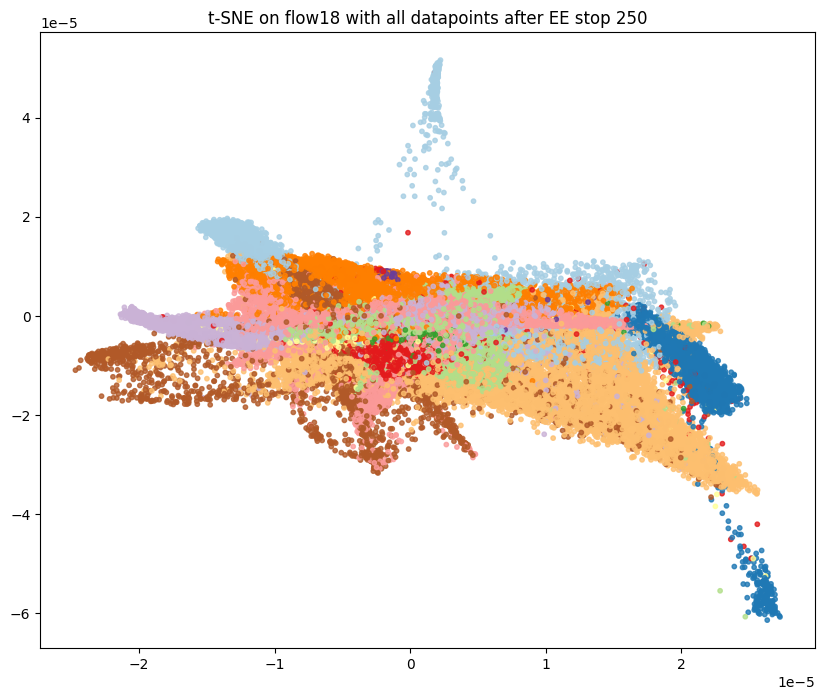

In [10]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(EE250_embedding[:, 0], EE250_embedding[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints after EE stop 250")
plt.show()

In [11]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed = KLDTracker(record_every=10)

final_embedding_short = EE250_embedding.optimize(n_iter=750, learning_rate=200, momentum=0.8, callbacks=kld_tracker_embed, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 468.5162 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 357.3700 sec
Iteration  150, KL divergence 9.7229, 50 iterations in 395.1691 sec
Iteration  200, KL divergence 9.7070, 50 iterations in 376.0475 sec
Iteration  250, KL divergence 9.2134, 50 iterations in 389.6704 sec
Iteration  300, KL divergence 8.5741, 50 iterations in 723.0461 sec
Iteration  350, KL divergence 8.2239, 50 iterations in 312.7858 sec
Iteration  400, KL divergence 7.9928, 50 iterations in 311.2318 sec
Iteration  450, KL divergence 7.8188, 50 iterations in 310.4529 sec
Iteration  500, KL divergence 7.6777, 50 iterations in 368.7826 sec
Iteration  550, KL divergence 7.5579, 50 iterations in 479.4399 sec
Iteration  600, KL divergence 7.4527, 50 iterations in 410.0546 sec
Iteration  650, KL divergence 7.3582, 50 iterations in 374.8959 sec
Iteration  700, KL divergence 7.27

In [12]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(final_embedding_short, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE250_1000iter_new_param.csv', index=False)

missing so far: KLD plot (TODO)

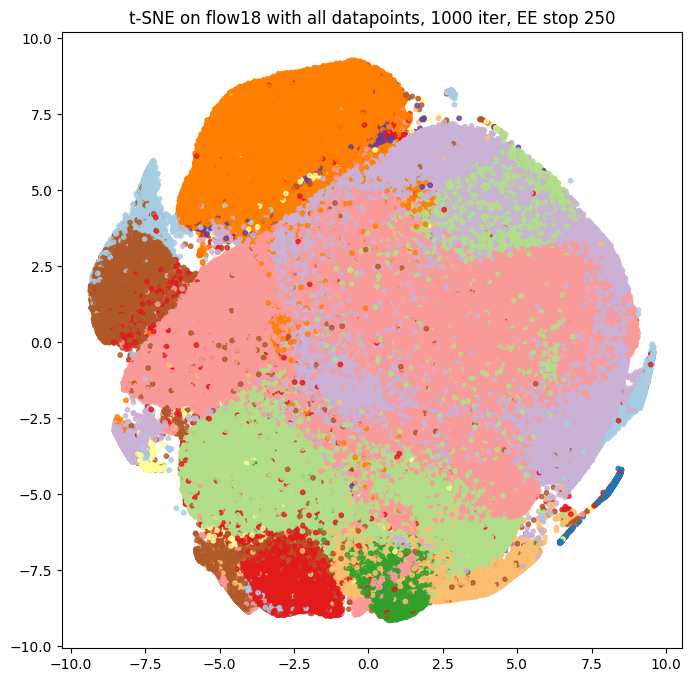

In [13]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(final_embedding_short[:, 0], final_embedding_short[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints, 1000 iter, EE stop 250")
plt.show()

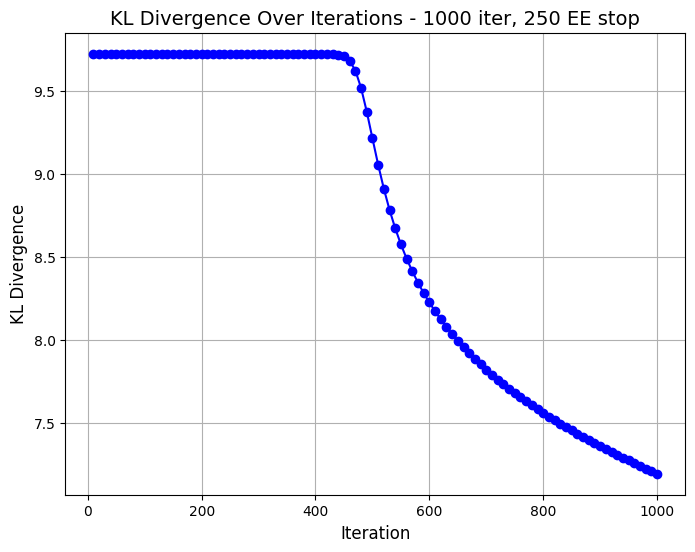

In [14]:
adjusted_divergences = [(iterations + 250, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 1000 iter, 250 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

#### total iter: 3000, EE stop: 750

In [15]:
## step 4: EE phase 
kld_tracker_EE2 = KLDTracker(record_every=10)
EE750_embedding = embedding.optimize(n_iter=750, learning_rate=200, momentum=0.5, exaggeration=12, callbacks= kld_tracker_EE2, callbacks_every_iters=10, verbose=True)

KeyboardInterrupt: 

In [18]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(EE750_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE750.csv', index=False)

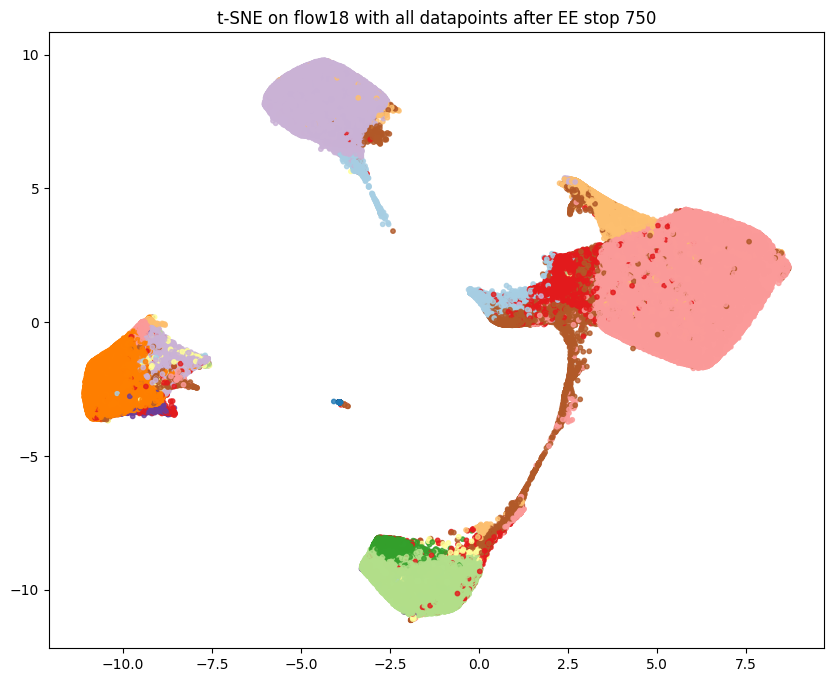

In [19]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(EE750_embedding[:, 0], EE750_embedding[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints after EE stop 750")
plt.show()

In [20]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed2 = KLDTracker(record_every=10)

final_embedding_long = EE750_embedding.optimize(n_iter=2250, callbacks=kld_tracker_embed2, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1.00, lr=1000021.00 for 2250 iterations...
Iteration   50, KL divergence 6.0028, 50 iterations in 240.1168 sec
Iteration  100, KL divergence 5.6883, 50 iterations in 231.4797 sec
Iteration  150, KL divergence 5.5171, 50 iterations in 231.3887 sec
Iteration  200, KL divergence 5.4028, 50 iterations in 243.8033 sec
Iteration  250, KL divergence 5.3179, 50 iterations in 242.6175 sec
Iteration  300, KL divergence 5.2508, 50 iterations in 245.8871 sec
Iteration  350, KL divergence 5.1956, 50 iterations in 891.2903 sec
Iteration  400, KL divergence 5.1489, 50 iterations in 250.1543 sec
Iteration  450, KL divergence 5.1085, 50 iterations in 263.4240 sec
Iteration  500, KL divergence 5.0730, 50 iterations in 254.2741 sec
Iteration  550, KL divergence 5.0413, 50 iterations in 265.3323 sec
Iteration  600, KL divergence 5.0128, 50 iterations in 492.5010 sec
Iteration  650, KL divergence 4.9869, 50 iterations in 303.4566 sec
Iteration  700, KL divergence

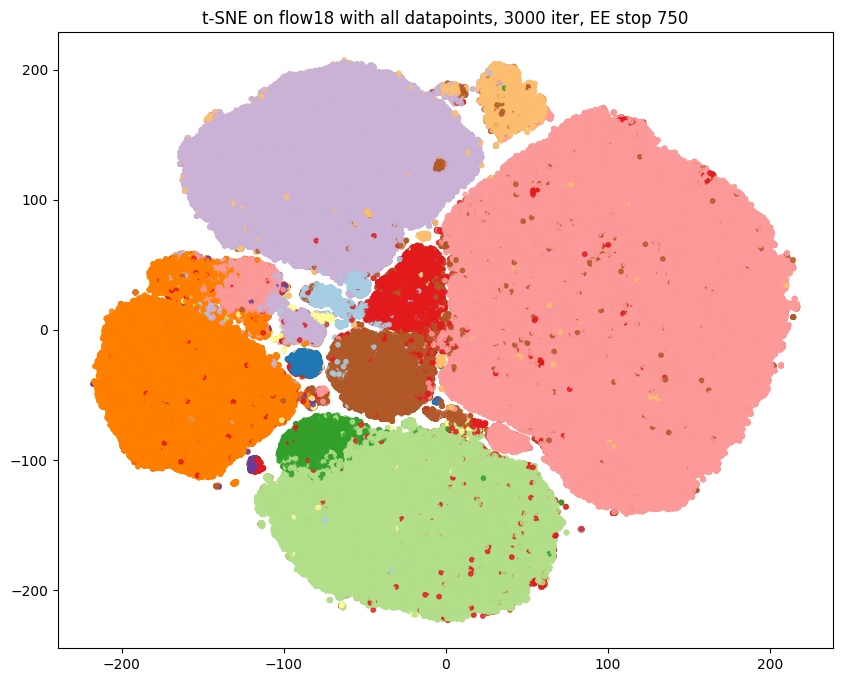

In [21]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(final_embedding_long[:, 0], final_embedding_long[:, 1], c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
plt.title("t-SNE on flow18 with all datapoints, 3000 iter, EE stop 750")
plt.show()

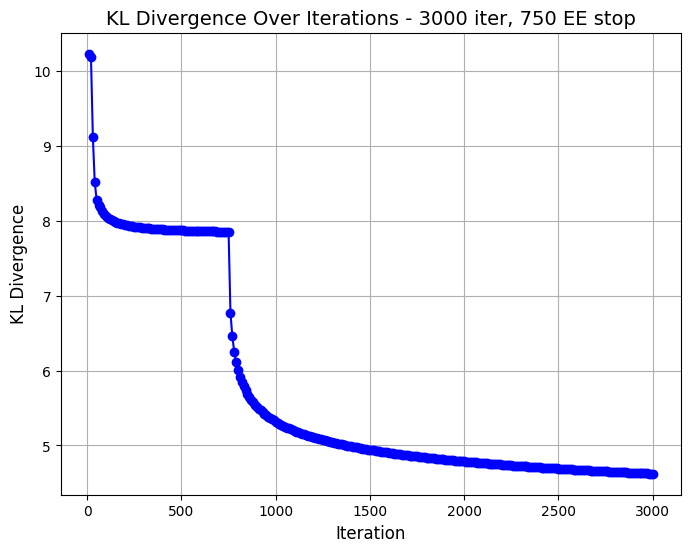

In [26]:
adjusted_divergences = [(iterations + 750, errors) for (iterations, errors) in kld_tracker_embed2.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE2.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 3000 iter, 750 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

In [22]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(final_embedding_long, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('flow18_EE750_3000iter_new_param.csv', index=False)

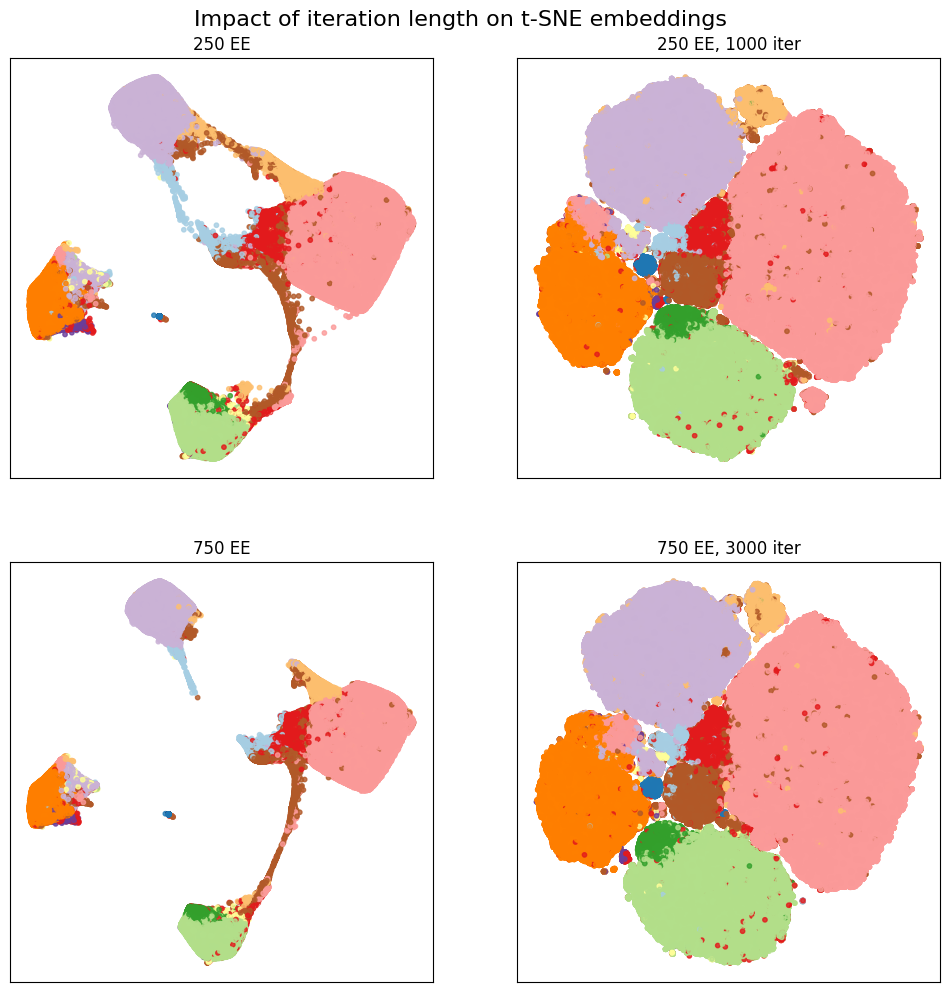

In [ ]:
# List of embeddings
all_embeddings = [EE250_embedding, final_embedding_short, EE750_embedding, final_embedding_long]

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Title for the entire figure
fig.suptitle("Impact of iteration length on t-SNE embeddings", fontsize=16, y=0.92)

# Subtitles for each subplot
subtitles = ["250 EE", "250 EE, 1000 iter", "750 EE", "750 EE, 3000 iter"]

# Plot each embedding in the corresponding subplot
for ax, embedding, subtitle in zip(axes.flat, all_embeddings, subtitles):
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                          c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
    ax.set_xticks([])  # Hide x ticks
    ax.set_yticks([])  # Hide y ticks
    ax.set_title(subtitle, fontsize=12)  # Subtitle for each subplot

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the main title
plt.show()
